In [65]:
import pandas as pd
import numpy as np

import seaborn as sns
import matplotlib as mpl
import matplotlib.pyplot as plt
from matplotlib import cm
from matplotlib.colors import ListedColormap, LinearSegmentedColormap

from sklearn.model_selection import train_test_split
from sklearn.cluster import KMeans
from sklearn import preprocessing
from sklearn import metrics 
from sklearn.tree import export_graphviz

import pydot

from pprint import pprint

<br>

### Reading in & Formatting Data

In [79]:
df_ToU = pd.read_csv('data/df_ToU.csv')
df_ToU.head(10)

,id,low_delta,high_delta,combined_DRS,DRS_rank,DoY_drop_weekend_max_combined_mean,DoY_drop_weekend_max_combined_var,DoY_max_combined_mean,DoY_max_combined_var,DoY_min_combined_mean,...,pt_Semi_detached,pt_terraced,pt_terraced_mid,pt_in_commercial,pt_purpose_built_block_tenemant,pt_converted_house_building,sml_hallway,sml_dont_know,sml_living_rm,sml_kitchen
0,140,0.298468,-0.124587,0.423056,1025,1.209031,0.490244,1.090893,0.505867,0.036560,...,0,0,0,0,1,0,1,0,0,0
1,969,0.217026,-0.131711,0.348738,1024,1.979500,0.685826,1.984946,0.640269,0.027844,...,0,0,0,0,1,0,0,0,1,0
2,323,0.200940,-0.128602,0.329541,1023,1.705271,0.385953,1.788514,0.364977,0.105587,...,0,1,0,0,0,0,0,0,0,1
3,144,0.250917,-0.077235,0.328152,1022,0.596357,0.185173,0.611358,0.177652,0.057974,...,0,0,1,0,0,0,0,0,0,0
4,656,0.207729,-0.079527,0.287256,1019,1.452321,0.184370,1.485547,0.227647,0.064797,...,0,1,0,0,0,0,0,0,0,1
5,186,0.076935,-0.208825,0.285761,1018,1.802891,0.158895,1.826480,0.167149,0.108202,...,0,0,1,0,0,0,0,1,0,0
6,847,0.156375,-0.111801,0.268175,1016,1.209869,0.298420,1.215270,0.300443,0.035959,...,0,0,1,0,0,0,0,0,0,1
7,423,0.168689,-0.089759,0.258448,1015,1.637021,0.320432,1.669904,0.325384,0.027476,...,0,0,0,0,1,0,0,0,0,1
8,143,0.131981,-0.123658,0.255639,1014,1.174806,0.121448,1.181813,0.135508,0.075731,...,1,0,0,0,0,0,0,0,0,1
9,693,0.168262,-0.086269,0.254531,1013,0.840942,0.152342,0.961063,0.210607,0.050159,...,0,0,1,0,0,0,0,0,0,0


<br>

### ML Model Data Preparation

In [67]:
idx_cols = df_ToU.columns
idx_SPs = idx_cols[(idx_cols.str[:2]=='SP') & (idx_cols.str.len()<11)]
SP_means_list = list(idx_SPs[idx_SPs.str[-1:]=='n'])
SP_vars_list = list(idx_SPs[idx_SPs.str[-1:]=='r'])

SP_vars_list[:10]

['SP_10_var',
 'SP_11_var',
 'SP_12_var',
 'SP_13_var',
 'SP_14_var',
 'SP_15_var',
 'SP_16_var',
 'SP_17_var',
 'SP_18_var',
 'SP_19_var']

In [68]:
response_list = ['low_delta', 'high_delta', 'combined_DRS', 'DRS_rank']
feature_list = list(df_ToU.drop(columns=response_list))

## Setting target variable
target = response_list[0]
features = SP_vars_list#[:5] + feature_list[53:] #feature_list[5:53]

In [69]:
var_cols_2_drop_list = list(set(df_ToU.columns) - set(SP_vars_list))
mean_cols_2_drop_list = list(set(df_ToU.columns) - set(SP_means_list))

df_ToU_var = df_ToU.copy().drop(columns=var_cols_2_drop_list)
df_ToU_mean = df_ToU.copy().drop(columns=mean_cols_2_drop_list)

df_ToU_mean.columns = df_ToU_mean.columns.str[3:-5].astype(int)
df_ToU_var.columns = df_ToU_var.columns.str[3:-4].astype(int)

s_household_mean_means = df_ToU_mean.mean(axis=1)
s_household_var_means = df_ToU_var.mean(axis=1)

def normalise_by_household_means(df, s_household_means):
    df_mean = df.copy()
    for col in df.keys():
        df_mean[col] = df_mean[col]/s_household_means
    return df_mean

df_ToU_mean_norm = normalise_by_household_means(df_ToU_mean, s_household_mean_means)
df_ToU_var_norm = normalise_by_household_means(df_ToU_var, s_household_var_means)

(1, 48)

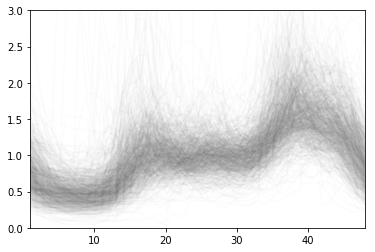

In [70]:
df_ToU_mean_norm_plot = df_ToU_mean_norm.T.sort_index()

for col in df_ToU_mean_norm_plot.keys():
    plt.plot(df_ToU_mean_norm_plot.index, df_ToU_mean_norm_plot[col], '-', color='grey', alpha=0.025)
    
plt.ylim(0, 3)
plt.xlim(1, 48)

(1, 48)

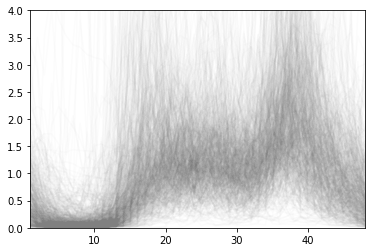

In [88]:
df_ToU_var_norm_plot = df_ToU_var_norm.T.sort_index()

for col in df_ToU_var_norm_plot.keys():
    plt.plot(df_ToU_var_norm_plot.index, df_ToU_var_norm_plot[col], '-', color='grey', alpha=0.025)
    
plt.ylim(0, 4)
plt.xlim(1, 48)

<br>

### Clustering

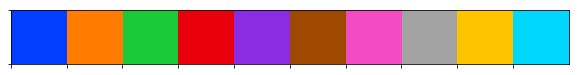

In [72]:
palette = sns.color_palette(palette='bright')
sns.palplot(palette)

In [73]:
def auto_cluster(df, n_clusters):
    X = np.array(df)

    n_clusters = n_clusters
    kmeans = KMeans(n_clusters=n_clusters, n_init=10, max_iter=300, random_state=42)
    kmeans = kmeans.fit(X)
    y_pred = kmeans.predict(X)
    
    df = df.assign(cluster=y_pred)
    
    print('Cluster Counts:')
    print(df.cluster.value_counts())

    return df

def plot_clusters(df, n_clusters, palette, ylim_max_sep=None):
    plt.figure()
        
    for cluster in range(n_clusters):
        df_plot = (df.copy()
                                 [df.cluster==cluster]
                                 .drop(columns='cluster')
                                 .T
                                 .sort_index())
        
        for col in df_plot.keys():
            plt.plot(df_plot.index, df_plot[col], '-', color=palette[cluster], alpha=0.05)

    plt.xlim(1, 48)
    if isinstance(ylim_max_sep, (float, int)):
        plt.ylim(0, ylim_max_sep)

def plot_cluster_averages(df_ToU_mean_norm, n_clusters, palette, ylim_max_agg=None):
    plt.figure()
        
    for cluster in range(n_clusters):
        df_ToU_mean_norm_cluster = df_ToU_mean_norm[df_ToU_mean_norm.cluster==cluster]
        s_ToU_mean_norm_cluster = df_ToU_mean_norm_cluster.mean().drop('cluster').sort_index()
        
        if df_ToU_mean_norm_cluster.shape[0] > 25:
            s_ToU_mean_norm_cluster.plot(style='--', color=palette[cluster], label=cluster)

    plt.xlim(1, 48)
    if isinstance(ylim_max_agg, (float, int)):
        plt.ylim(0, ylim_max_agg)
        
    plt.legend(frameon=False)
    
def cluster_and_plot(df, n_clusters, palette, title, ylim_max_agg=None, ylim_max_sep=3):
    df = auto_cluster(df, n_clusters)
    
    plot_cluster_averages(df, n_clusters, palette, ylim_max_agg=ylim_max_agg)
    plt.title(f'Aggregated {title}')
    
    plot_clusters(df, n_clusters, palette, ylim_max_sep=ylim_max_sep)
    plt.title(f'{title}')
    
    return df

Normalised Mean by SP
Cluster Counts:
3    257
1    205
0    195
2    123
Name: cluster, dtype: int64

Normalised Variance by SP
Cluster Counts:
2    259
0    216
3    181
1    124
Name: cluster, dtype: int64


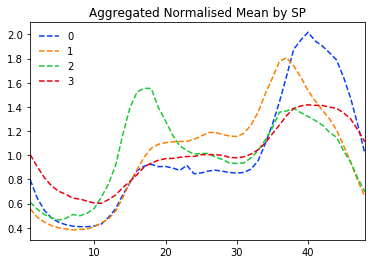

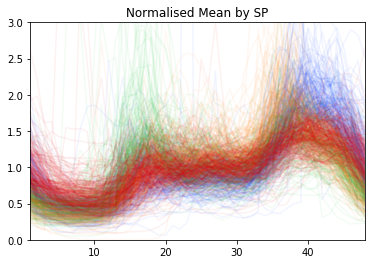

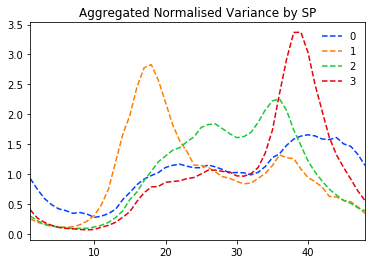

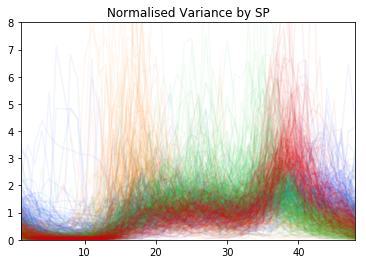

In [100]:
n_clusters = 4

title = 'Normalised Mean by SP'
print(title)
df_ToU_mean_norm_clustered = cluster_and_plot(df_ToU_mean_norm, n_clusters, palette, title)

print('')
title = 'Normalised Variance by SP'
print(title)
df_ToU_var_norm_clustered = cluster_and_plot(df_ToU_var_norm, n_clusters, palette, title, ylim_max_sep=8)

In [106]:
df_ToU_mean_norm_clustered.columns = [f'SP_{x}_norm_mean' for x in df_ToU_mean_norm_clustered.columns]
df_ToU_var_norm_clustered.columns = [f'SP_{x}_norm_var' for x in df_ToU_var_norm_clustered.columns]

df_ToU_mean_norm_clustered['id'] = df_ToU['id']
df_ToU_var_norm_clustered['id'] = df_ToU['id']

df_ToU_mean_norm_clustered.to_csv('data/df_ToU_mean_norm_clustered.csv')
df_ToU_var_norm_clustered.to_csv('data/df_ToU_var_norm_clustered.csv')

df_ToU_var_norm_clustered.head(10)

,SP_10_norm_var,SP_11_norm_var,SP_12_norm_var,SP_13_norm_var,SP_14_norm_var,SP_15_norm_var,SP_16_norm_var,SP_17_norm_var,SP_18_norm_var,SP_19_norm_var,...,SP_47_norm_var,SP_48_norm_var,SP_4_norm_var,SP_5_norm_var,SP_6_norm_var,SP_7_norm_var,SP_8_norm_var,SP_9_norm_var,SP_cluster_norm_var,id
0,0.019958,0.015230,0.042052,0.111678,0.064302,0.442248,0.955056,1.516714,2.739213,2.875793,...,0.865374,0.724495,0.130568,0.160494,0.061328,0.094711,0.082614,0.054892,1,140
1,0.001300,0.001176,0.007722,0.041392,0.267401,0.587869,1.197158,1.544946,1.919685,1.971440,...,0.861643,0.831535,0.052202,0.003583,0.001590,0.001514,0.001338,0.001230,3,969
2,0.480971,0.102472,0.054693,0.074898,0.101195,0.191156,0.448635,0.622290,0.929413,0.989643,...,1.424833,1.277829,0.434495,0.292975,0.095418,0.149539,0.102196,0.105499,0,323
3,0.302754,0.293984,0.325484,0.341024,0.349478,0.275322,0.354732,0.407858,0.811331,0.596400,...,2.324698,2.333603,1.272309,0.736537,0.560964,0.498227,0.335848,0.316536,0,144
4,0.420707,0.348624,0.219269,0.499197,0.779261,1.278653,2.107574,1.751640,1.718799,1.985543,...,0.043128,0.028037,0.402429,0.102276,0.051175,0.010617,0.023339,0.065637,2,656
5,0.030014,0.697898,0.389317,0.998357,1.079248,1.886586,1.429411,2.554478,1.922482,2.046012,...,0.082458,0.049477,0.031199,0.028051,0.030442,0.027848,0.028811,0.030438,1,186
6,0.045109,0.034559,0.020538,0.048135,0.106874,0.260979,0.375166,0.480174,0.775591,0.861988,...,0.976340,0.730126,0.157784,0.152591,0.172966,0.124294,0.045434,0.030919,3,847
7,1.123387,0.863476,1.941058,2.736715,0.883499,0.306195,0.195779,0.568292,1.155599,0.885479,...,0.701701,0.603274,0.028969,0.026354,0.024812,0.024327,0.073433,0.210532,3,423
8,0.424096,0.413454,0.384152,0.368823,0.380481,0.744804,0.829874,0.767093,0.822010,0.910297,...,1.147002,0.956516,0.149737,0.163691,0.132030,0.118391,0.242363,0.307421,0,143
9,0.020217,0.031124,0.168850,0.201122,0.440306,0.955371,0.385591,0.744659,0.736714,0.806703,...,0.782069,0.785922,0.362495,0.162039,0.183238,0.063203,0.067247,0.022560,2,693


In [105]:
#df_ToU_mean_norm_clustered.groupby(by='cluster').mean().T.sort_index().to_json('data/mean_norm_clustered.json')
#df_ToU_var_norm_clustered.groupby(by='cluster').mean().T.sort_index().to_json('data/var_norm_clustered.json')